Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = "" # put your full name here
COLLABORATORS = [] # list anyone you collaborated with on this workbook

---

## Lab 6: Multiple Regression and Geopandas (Part 2)
**This lab was distributed the week of October 5th and should be completed by Tuesday, 10/13/2020 at 11:59PM.**

-------------------------------------------

Welcome to your sixth lab of the semester!<br>

This lab continues to build on the spatial analysis and modeling skills we have been developing in previous assignments. Specifically, we will use Geopandas and the `statsmodels` library to try to predict the area burned by large wildfires in the Sierra Nevada region of California. 

Feel free to refer to Lab 3 for the basic Geopandas methods we learned a few weeks ago, and to Lab 5 for linear regression (single variable) basics. 

## Setup & Review

Let's begin by importing the packages we'll need.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd

%matplotlib inline

The first dataset we will examine is fire perimeter data from the [Monitoring Trends in Burn Severity (MTBS)](https://www.mtbs.gov/project-overview) database. The data are stored as shapefiles in the `data/mtbs_ca` folder. To reduce the file size, we pre-processed the original, nationwide data to only include data for the Sierra Nevada region (as defined by [the Sierra Nevada Conservancy boundary](https://gis.data.ca.gov/datasets/f147fdc76a104484b9fa90baacf9462f_0?geometry=-133.799%2C35.544%2C-106.047%2C41.552)). The raw MTBS data includes information about prescribed fires and wildfires; in this lab, we have filtered out all fire types except for wildfires. 

**Question 1:** Import the shapefile as a GeoDataFrame. Print the first few rows. 

In [3]:
# YOUR CODE HERE
sn_wildfires = gpd.read_file('data/mtbs_sn/mtbs_sn.shp')
sn_wildfires.head()

,Fire_ID,Fire_Name,Year,StartMonth,StartDay,Fire_Type,Acres,geometry
0,CA3525911854920000802,PEAK,2000,8,2,Wildfire,1316.0,"POLYGON ((-118.56981 35.26986, -118.56964 35.2..."
1,CA3534111823820120810,JAWBONE COMPLEX,2012,8,10,Wildfire,12212.0,"MULTIPOLYGON (((-118.22539 35.30764, -118.2253..."
2,CA3541611826720060805,COTTONWOOD,2006,8,5,Wildfire,2386.0,"POLYGON ((-118.29174 35.41341, -118.29188 35.4..."
3,CA3543011843920030723,BASIN,2003,7,23,Wildfire,1051.0,"POLYGON ((-118.42060 35.43559, -118.41990 35.4..."
4,CA3545811870719850628,RICH BAR,1985,6,28,Wildfire,8141.0,"POLYGON ((-118.74454 35.48176, -118.74371 35.4..."


**Question 2:** Let's do a very light EDA of `sn_wildfire` dataframe, focusing on granularity and scope. Using the project information linked above and your own exploration of the dataframe, answer the questions below: <br>
a. What is the temporal extent of the data? *(scope)*<br>
b. What sizes of fires are included in MTBS? What land ownership types? *(scope)*<br>
c. What is the temporal resolution of the data? *(granularity)*<br>
d. How many records are there, and what does each record represent? *(granularity)*<br>
e. What is the coordinate reference system (CRS) of the data? *(structure)* <br>
f. What type of geometries are included in the dataframe?

In [4]:
#scratch work here
print(sn_wildfires.shape)
print(sn_wildfires.crs)
sn_wildfires.geometry.type.unique()

(420, 8)
epsg:4269


array(['Polygon', 'MultiPolygon'], dtype=object)

*Solution*

a. The data are available for the period 1984-2018.<br>
b. The data include all fires >= 1000 acres in the western U.S. and >=500 acres in the eastern U.S. All land ownerships are included.<br>
c. The data are recorded by start date of the fire. We know the year, month, and day of each incident.<br>
d. There are 420 records. Each record represents a unique fire incident. Complexes may include two or more incidents in the same area. <br> 
e. The data are in the NAD83 (EPSG: 4269) CRS. <br>
f. The dataframe contains Polygon and MultiPolygon objects.

**Question 3:** Print the geometry for one Polygon and one Multipolygon of your choice in the dataframe. Your answer should be a rendering of each object.

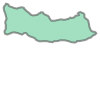

In [5]:
# Print the geometry of a Polygon of your choice. 
sn_wildfires.loc[0,'geometry']

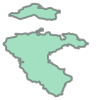

In [6]:
# Print the geometry of a MultiPolygon of your choice.
sn_wildfires.loc[sn_wildfires.geometry.type=='MultiPolygon']
sn_wildfires.loc[1,'geometry']

## More handy Geopandas operations

Geopandas provides a veritable treasure trove of [methods and attributes for Geoseries](https://geopandas.org/reference.html) (as a reminder, in a GeoDataFrame, a Geoseries is the column that contains the `geometry` attribute. That column is often, but not always, named "geometry"). Let's try out a few of these methods on our `sn_wildfires` data.

In our `sn_wildfire` dataframe, each geometry represents the perimeter of the area burned by a wildfire incident. We can use Geopandas operations to explore different properties of these geometries. 

For example, we might want to know the **centroid** of each burned area:

In [7]:
sn_wildfires.geometry.centroid.head()

# equivalently, we could have called sn_wildfires['geometry'].centroid

<ipython-input-7-643f9b54a935>:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sn_wildfires.geometry.centroid.head()


0    POINT (-118.54871 35.25947)
1    POINT (-118.22728 35.28013)
2    POINT (-118.26734 35.41600)
3    POINT (-118.43934 35.43035)
4    POINT (-118.70713 35.45845)
dtype: geometry

We can also obtain the **area**... 

In [8]:
sn_wildfires.geometry.area.head()

<ipython-input-8-6845d76e0c52>:1: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sn_wildfires.geometry.area.head()


0    0.000528
1    0.004896
2    0.000958
3    0.000422
4    0.003271
dtype: float64

... and the **perimeter** each Polygon:

In [9]:
sn_wildfires.geometry.length.head()

<ipython-input-9-4ae57cb7af1f>:1: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sn_wildfires.geometry.length.head()


0    0.126157
1    0.625025
2    0.155880
3    0.159737
4    0.353019
dtype: float64

In this case, our dataframe already included an area metric, specifically, the `Acres` column. 

**Question 4:** Your centroid, perimeter, and area calls probably returned the following warning:  
`Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.`

Why does Python give you this warning? What are the units of area and length returned by the Geopandas built-in methods? *Hint:* it might be helpful to [look up the CRS](https://epsg.org/home.html) for this dataset. 

*YOUR ANSWER HERE*

*The units of measure depend on the CRS! In this case, we are working the NAD83 projection, whose unit of measurement is the degree. So, our area is expressed in radian degrees squared, and our perimeter in radian degrees. Not very intuitive units in which to work! If we wanted to remove the warning, we could reproject our dataframe into an equal area or equal distance CRS.*

In this lab, we will try to predict the area burned by a wildfire (using `Acres` as our response variable), using start day and (relative) distance to the nearest highway as independent variables. For the latter, we will need [data on the locations of primary roads (i.e., interstates and highways) in the U.S](https://catalog.data.gov/dataset/tiger-line-shapefile-2016-nation-u-s-primary-roads-national-shapefile/resource/d7153734-1bce-4cb6-9882-466ecf897b65). 

**Question 5:** Open the shapefile in `data/tl_2016_us_primaryroads/` as a GeoDataFrame named `roads`. Does the dataset need to be transformed to a different CRS? 

In [10]:
# YOUR CODE HERE
sn_roads = gpd.read_file('data/tl_2016_us_primaryroads/tl_2016_us_primaryroads_sn.shp')
sn_roads.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - NAD83
- bounds: (167.65, 14.92, -47.74, 86.46)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

*YOUR ANSWER HERE*

*The data are already in the same CRS as `sn_wildfires`, so they don't need to be transformed. Hooray!* 

**Question 6:** How many records are in `sn_roads`, and what do they represent? What type of geometry are the objects in the `sn_roads` dataframe?

In [11]:
print(sn_roads.geometry.type.unique())
sn_roads

['LineString']


,LINEARID,FULLNAME,RTTYP,MTFCC,geometry
0,1102217388786,I- 80,I,S1100,"LINESTRING (-120.43714 39.31619, -120.43682 39..."
1,110434220835,I- 80,I,S1100,"LINESTRING (-120.01032 39.44512, -120.01020 39..."
2,110434220836,I- 80,I,S1100,"LINESTRING (-120.01048 39.44512, -120.01011 39..."
3,110809146095,State Rte 89,S,S1100,"LINESTRING (-120.20778 39.32318, -120.20772 39..."
4,110687705699,State Rte 193,S,S1100,"LINESTRING (-121.07479 38.90028, -121.07482 38..."
5,1104259561602,State Rte 193,S,S1100,"LINESTRING (-121.12589 38.87812, -121.12551 38..."
6,1103017265103,I- 80,I,S1100,"LINESTRING (-120.62489 39.31541, -120.62454 39..."
7,1104469669293,I- 80,I,S1100,"LINESTRING (-120.43536 39.31619, -120.43020 39..."
8,1104748193081,I- 80,I,S1100,"LINESTRING (-120.55669 39.31560, -120.55626 39..."
9,1104748193082,I- 80,I,S1100,"LINESTRING (-120.55669 39.31560, -120.55704 39..."


*YOUR ANSWER HERE*

*Roads are represented as Linestrings. There are 12 records, each representing a segment of a state or interstate highway that intersects with the Sierra Nevada boundary.*

**Question 7:** Use Geopandas operations to find the length of each road in `sn_roads`.

In [12]:
# YOUR CODE HERE
sn_roads.geometry.length

<ipython-input-12-e050b94a2100>:2: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sn_roads.geometry.length


0     0.543522
1     0.024747
2     0.025021
3     0.042921
4     0.056950
5     0.057037
6     0.079520
7     0.542268
8     0.128763
9     0.069052
10    0.125406
11    0.042943
dtype: float64

Geopandas can also calculate the distance between geometries. The code below finds the nearest distance between each road in `sn_roads` and the centroid of the first wildfire listed in `sn_wildfires`. 

In [13]:
dsts = sn_roads.distance(sn_wildfires.centroid.loc[0])
dsts

<ipython-input-13-318b611d0f71>:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dsts = sn_roads.distance(sn_wildfires.centroid.loc[0])
<ipython-input-13-318b611d0f71>:1: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dsts = sn_roads.distance(sn_wildfires.centroid.loc[0])


0     4.373209
1     4.433503
2     4.433554
3     4.385914
4     4.430710
5     4.430541
6     4.525344
7     4.372945
8     4.473975
9     4.525943
10    4.474721
11    4.385728
dtype: float64

**Question 8:** Write a function that takes in a single point ("point") and a series of linestrings ("lines") and returns the distance between that point and the nearest line.

In [14]:
# YOUR CODE HERE
def min_distance(point, lines):
    return lines.distance(point).min()

In [15]:
assert min_distance(sn_wildfires.centroid[0], sn_roads) == dsts.min()

<ipython-input-15-e2d16e3b7970>:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  assert min_distance(sn_wildfires.centroid[0], sn_roads) == dsts.min()
<ipython-input-14-06810d5428e1>:3: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  return lines.distance(point).min()


**Question 9:** Using your `min_distance` function, add a new column to `sn_wildfires`, each of whose elements represents the distance between the centroid of the burned area and the nearest major road in `sn_roads`. Name this column "dst_to_rd."

In [16]:
# YOUR CODE HERE
sn_wildfires['dist_to_rd']=[min_distance(sn_wildfires.centroid[i],sn_roads) for i in sn_wildfires.index]

<ipython-input-16-f24881942e6d>:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sn_wildfires['dist_to_rd']=[min_distance(sn_wildfires.centroid[i],sn_roads) for i in sn_wildfires.index]
<ipython-input-14-06810d5428e1>:3: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  return lines.distance(point).min()


In [17]:
sn_wildfires.head()

,Fire_ID,Fire_Name,Year,StartMonth,StartDay,Fire_Type,Acres,geometry,dist_to_rd
0,CA3525911854920000802,PEAK,2000,8,2,Wildfire,1316.0,"POLYGON ((-118.56981 35.26986, -118.56964 35.2...",4.372945
1,CA3534111823820120810,JAWBONE COMPLEX,2012,8,10,Wildfire,12212.0,"MULTIPOLYGON (((-118.22539 35.30764, -118.2253...",4.473502
2,CA3541611826720060805,COTTONWOOD,2006,8,5,Wildfire,2386.0,"POLYGON ((-118.29174 35.41341, -118.29188 35.4...",4.333064
3,CA3543011843920030723,BASIN,2003,7,23,Wildfire,1051.0,"POLYGON ((-118.42060 35.43559, -118.41990 35.4...",4.252521
4,CA3545811870719850628,RICH BAR,1985,6,28,Wildfire,8141.0,"POLYGON ((-118.74454 35.48176, -118.74371 35.4...",4.132690


## Multi-Variable Regression

In addition to distance to the nearest highway, we want to use day of the year that the fire starts as an independent variable. To facilitate this analysis, let's make a new column in our `sn_wildfires` dataframe that combines the information from the `year`, `StartMonth`, and `StartDay` columns into a Pandas datetime object.

In [18]:
sn_wildfires['date'] = pd.to_datetime({'year':sn_wildfires['Year'],
                      'month':sn_wildfires['StartMonth'],
                      'day':sn_wildfires['StartDay']})
sn_wildfires.head()

,Fire_ID,Fire_Name,Year,StartMonth,StartDay,Fire_Type,Acres,geometry,dist_to_rd,date
0,CA3525911854920000802,PEAK,2000,8,2,Wildfire,1316.0,"POLYGON ((-118.56981 35.26986, -118.56964 35.2...",4.372945,2000-08-02
1,CA3534111823820120810,JAWBONE COMPLEX,2012,8,10,Wildfire,12212.0,"MULTIPOLYGON (((-118.22539 35.30764, -118.2253...",4.473502,2012-08-10
2,CA3541611826720060805,COTTONWOOD,2006,8,5,Wildfire,2386.0,"POLYGON ((-118.29174 35.41341, -118.29188 35.4...",4.333064,2006-08-05
3,CA3543011843920030723,BASIN,2003,7,23,Wildfire,1051.0,"POLYGON ((-118.42060 35.43559, -118.41990 35.4...",4.252521,2003-07-23
4,CA3545811870719850628,RICH BAR,1985,6,28,Wildfire,8141.0,"POLYGON ((-118.74454 35.48176, -118.74371 35.4...",4.132690,1985-06-28


**Question 10:** Add a column called "day_of_year" to `sn_wildfires`. Each element of this column will be an integer between 1 and 365 representing the day of the year. *Hint:* You've done this before! Refer to Homework 3. 

In [19]:
# YOUR CODE HERE
sn_wildfires['day_of_year']=sn_wildfires['date'].dt.dayofyear
sn_wildfires.head()

,Fire_ID,Fire_Name,Year,StartMonth,StartDay,Fire_Type,Acres,geometry,dist_to_rd,date,day_of_year
0,CA3525911854920000802,PEAK,2000,8,2,Wildfire,1316.0,"POLYGON ((-118.56981 35.26986, -118.56964 35.2...",4.372945,2000-08-02,215
1,CA3534111823820120810,JAWBONE COMPLEX,2012,8,10,Wildfire,12212.0,"MULTIPOLYGON (((-118.22539 35.30764, -118.2253...",4.473502,2012-08-10,223
2,CA3541611826720060805,COTTONWOOD,2006,8,5,Wildfire,2386.0,"POLYGON ((-118.29174 35.41341, -118.29188 35.4...",4.333064,2006-08-05,217
3,CA3543011843920030723,BASIN,2003,7,23,Wildfire,1051.0,"POLYGON ((-118.42060 35.43559, -118.41990 35.4...",4.252521,2003-07-23,204
4,CA3545811870719850628,RICH BAR,1985,6,28,Wildfire,8141.0,"POLYGON ((-118.74454 35.48176, -118.74371 35.4...",4.132690,1985-06-28,179


At this point, we've prepared our data for to fit a regression model. Before we do so, let's visualize the data and qualitatively try to identify any patterns or trends.

**Question 11:** Create a pair of scatter plots showing the relationship between `Acres` burned (the target variable, represented on the y-axis), and each of the independent variables (`day_of_year` and `dist_to_rd`, represented on the x-axes). Do you notice any trends? What happens if you log-transform the y-axis?

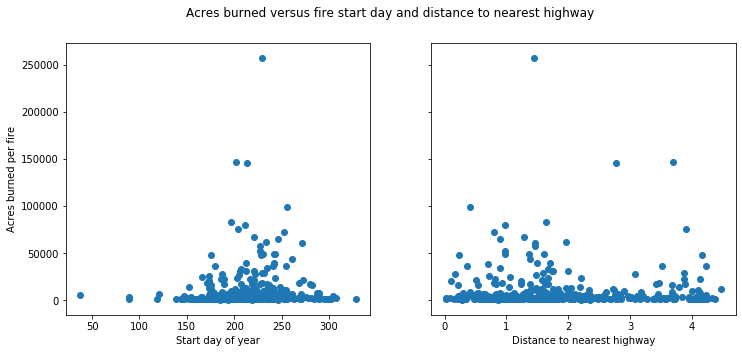

In [20]:
#YOUR CODE HERE
fig, (ax0, ax1) = plt.subplots(ncols=2, sharey=True, figsize=(12,5))

ax0.scatter(sn_wildfires['day_of_year'],sn_wildfires['Acres'])
ax0.set_xlabel('Start day of year')
ax0.set_ylabel('Acres burned per fire')

ax1.scatter(sn_wildfires['dist_to_rd'],sn_wildfires['Acres'])
ax1.set_xlabel('Distance to nearest highway')

plt.suptitle('Acres burned versus fire start day and distance to nearest highway');

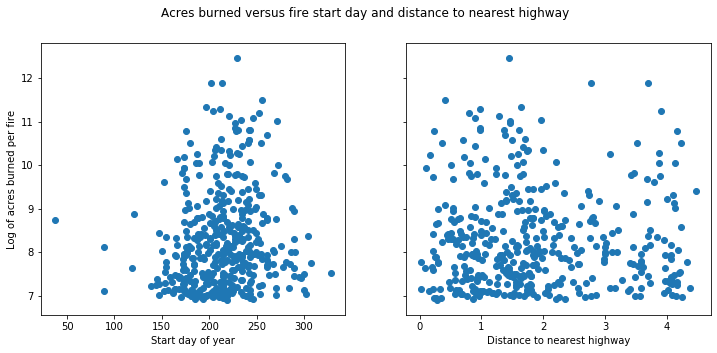

In [21]:
# This time using a logarithmic scale for area burned
fig, (ax0, ax1) = plt.subplots(ncols=2, sharey=True, figsize=(12,5))

ax0.scatter(sn_wildfires['day_of_year'],np.log(sn_wildfires['Acres']))
ax0.set_xlabel('Start day of year')
ax0.set_ylabel('Log of acres burned per fire')

ax1.scatter(sn_wildfires['dist_to_rd'],np.log(sn_wildfires['Acres']))
ax1.set_xlabel('Distance to nearest highway')

plt.suptitle('Acres burned versus fire start day and distance to nearest highway');

*YOUR OBSERVATION HERE*

*We can already see that the data are pretty noisy, making it difficult to identify clear trends. There seems to be somewhat of a trend of burned area peaking around day 225, and area burned seems to decrease somewhat as distance to the nearest highways grows.*

We are ready at last to create our linear regression model, using two features (start day and distance to nearest highway) to predict acres burned. 

This time, instead of `scikit-learn`, we'll use a library called `statsmodels`. One nice feature of `statsmodels` is its clean, informative summary of regression results and statistics.

In [22]:
# Run this cell to import the statsmodels library
import statsmodels.api as sm

Estimating a model with `statsmodels` uses a similar process to model estimation in `scikit-learn`. We first initialize a model, in this case using the `sm.OLS()` method, which takes **X** and **y** (in dataframe form) as arguments. We then `.fit()` the model and can view information about the coefficients and model performance using `.summary()`. 

**Question 12:** Create a dataframe **X**, which holds our two independent variables, each as a column of observations. In addition, create a dataframe **y** that holds the response variable.

In [23]:
# YOUR CODE HERE
X = sn_wildfires.loc[:,['dist_to_rd','day_of_year']]
y = sn_wildfires[['Acres']]

Unlike `scikit-learn`, statsmodels expects a column of 1's in the **X** dataframe in order to fit an intercept. One way to achieve this is to apply `statsmodel`'s built-in `add_constant` function to your dataframe of **X** values.

In [24]:
# run this cell
X_const = sm.add_constant(X)
X_const.head()

,const,dist_to_rd,day_of_year
0,1.0,4.372945,215
1,1.0,4.473502,223
2,1.0,4.333064,217
3,1.0,4.252521,204
4,1.0,4.132690,179


Run the cell below to fit a model to **X** and **y** and view the results.

In [25]:
# Run this cell
sn_wf_model = sm.OLS(y,X_const)
sn_wf_results = sn_wf_model.fit()
sn_wf_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Acres   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.247
Date:                Fri, 02 Oct 2020   Prob (F-statistic):              0.288
Time:                        13:21:52   Log-Likelihood:                -4767.0
No. Observations:                 420   AIC:                             9540.
Df Residuals:                     417   BIC:                             9552.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         -80.2188   6505.755     -0.012      0.990   -1.29e+04    1.27e+04
dist_to_rd     16.7265    890.168      0.019      0.985   -1733.050    1766.503
day_of_year    43.7832     27.959      1.566      0.118     -11.176      98.742
==============================================================================
Omnibus:                      553.279   Durbin-Watson:                   2.087
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            63938.015
Skew:                           6.457   Prob(JB):                         0.00
Kurtosis:                      62.049   Cond. No.                     1.40e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.4e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Question 13:** What are the values and 95% confidence intervals of the three coefficients? What do the confidence intervals imply about the model we've built?

*YOUR ANSWER HERE* 

*The confidence intervals are extremely wide and include 0. This means there is a >5% probability that there is actually no relationship between our independent and dependent variables.*

## Feature Engineering

Let's try to improve our model by adding more features. Instead of using new sources of data, we will transform the two independent variables we already have and add these transformations as additional features. This process is known as "feature engineering."

**Question 14** To make it easy to test different sets of features, write a function `fit_OLS` that takes in a dataframe containing the independent variables ($X$) and another dataframe containing response variable ($y$). The function should fit a linear regression model and output the `statsmodels` summary for the model. Feel free to use the code in the previous section as a template. Test your model on the $X$ and $y$ dataframes you created in Question 14.

In [26]:
# YOUR CODE HERE* 

def fit_OLS(X,y):
    X_const = sm.add_constant(X)
    ols_model = sm.OLS(y,X_const)
    results = ols_model.fit()
    return results.summary()

In [27]:
fit_OLS(X,y)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Acres   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.247
Date:                Fri, 02 Oct 2020   Prob (F-statistic):              0.288
Time:                        13:21:52   Log-Likelihood:                -4767.0
No. Observations:                 420   AIC:                             9540.
Df Residuals:                     417   BIC:                             9552.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         -80.2188   6505.755     -0.012      0.990   -1.29e+04    1.27e+04
dist_to_rd     16.7265    890.168      0.019      0.985   -1733.050    1766.503
day_of_year    43.7832     27.959      1.566      0.118     -11.176      98.742
==============================================================================
Omnibus:                      553.279   Durbin-Watson:                   2.087
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            63938.015
Skew:                           6.457   Prob(JB):                         0.00
Kurtosis:                      62.049   Cond. No.                     1.40e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.4e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The first new feature we will add to our model is the natural log of the `dist_to_rd` variable. The code block below provides an approach to expanding our $X$ dataframe to include this new feature.

In [28]:
X['log_dist'] = np.log(sn_wildfires['dist_to_rd'])
X.head()

,dist_to_rd,day_of_year,log_dist
0,4.372945,215,1.475437
1,4.473502,223,1.498172
2,4.333064,217,1.466275
3,4.252521,204,1.447512
4,4.132690,179,1.418929


**Question 15** Add two more features to $X$: a) the `day_of_year` variable squared, and b) $e^f$, where $f$ is `dist_to_rd`/`day_of_year`.   

*Note:* These new features don't necessarily have any intuitive meaning in the real world. We're just experimenting to see if we can come up with some new transformations that improve our model's performance. Since we are focusing on prediction and not inference, we don't have to understand the physical reasons why a particular transformation might work or not.

In [29]:
# YOUR ANSWER HERE

X['day^2'] = sn_wildfires['day_of_year']**2
X['e^(dist/day)'] = np.exp(sn_wildfires['dist_to_rd']/sn_wildfires['day_of_year'])
X.head()

,dist_to_rd,day_of_year,log_dist,day^2,e^(dist/day)
0,4.372945,215,1.475437,46225,1.020548
1,4.473502,223,1.498172,49729,1.020263
2,4.333064,217,1.466275,47089,1.020169
3,4.252521,204,1.447512,41616,1.021064
4,4.132690,179,1.418929,32041,1.023356


**Question 16** Use your `fit_OLS` function to estimate a model for your expanded $X$ feature set. Did the addtion of the transformed features improve the model? *Hint:* compare the AIC value for the model you estimated in the previous section to this one.

In [30]:
# YOUR CODE HERE
fit_OLS(X,y)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Acres   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     2.031
Date:                Fri, 02 Oct 2020   Prob (F-statistic):             0.0733
Time:                        13:21:52   Log-Likelihood:                -4763.2
No. Observations:                 420   AIC:                             9538.
Df Residuals:                     414   BIC:                             9563.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -1.492e+06   6.39e+05     -2.333      0.020   -2.75e+06   -2.35e+05
dist_to_rd   -7597.4873   3563.070     -2.132      0.034   -1.46e+04    -593.522
day_of_year    878.7177    307.800      2.855      0.005     273.672    1483.764
log_dist      1382.0128   2631.828      0.525      0.600   -3791.400    6555.426
day^2           -1.7649      0.651     -2.710      0.007      -3.045      -0.485
e^(dist/day)  1.397e+06   6.09e+05      2.295      0.022       2e+05    2.59e+06
==============================================================================
Omnibus:                      551.467   Durbin-Watson:                   2.085
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            63751.621
Skew:                           6.417   Prob(JB):                         0.00
Kurtosis:                      61.977   Cond. No.                     4.37e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.37e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

*YOUR ANSWER HERE*

*We did improve our model (AIC decreased by 2), but it's still pretty bad!*

**Question 17:** Take a stab at engineering at least one new feature of your own, using different transformations and/or combinations of the features in the $X$ dataframe. Fit your model and view the results. Did your new feature(s) improve the model?

In [31]:
# YOUR CODE HERE

*YOUR ANSWER HERE*

**Question 18:** Besides feature engineering, what else might you be able to do to build a model that better predicts burned area in the Sierra Nevada?

*YOUR ANSWER HERE*

*Answers may vary, but some ideas include: adding features based on other data sources (e.g., vegetation type, time since last fire,...), transforming the CRS to get more accurate measurements of centroid and distance, further narrowing the regional scope (e.g., to only look at mixed conifer ecosystems in the Sierra Nevada), etc.*

# Hooray, you're done! 

Please remember to submit your lab work, after clicking Kernel -> Restart & Run All, in .html and .ipynb format on bCourses.